<a href="https://colab.research.google.com/github/meenuraji/S5/blob/master/EVA4S5F10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [15]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
     
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
            
        ) 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU())
            
        
       
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()) 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU())
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU())      
          
        
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) 

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.gap(x)        
        x = self.convblock6(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3            [-1, 8, 24, 24]             576
              ReLU-4            [-1, 8, 24, 24]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Conv2d-6           [-1, 16, 10, 10]           1,152
              ReLU-7           [-1, 16, 10, 10]               0
            Conv2d-8             [-1, 16, 8, 8]           2,304
              ReLU-9             [-1, 16, 8, 8]               0
           Conv2d-10             [-1, 32, 6, 6]           4,608
             ReLU-11             [-1, 32, 6, 6]               0
        AvgPool2d-12             [-1, 32, 1, 1]               0
           Conv2d-13             [-1, 10, 1, 1]             320
Total params: 9,032
Trainable para

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3112488090991974 Batch_id=468 Accuracy=32.93: 100%|██████████| 469/469 [00:10<00:00, 46.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3999, Accuracy: 8811/10000 (88.11%)

EPOCH: 1


Loss=0.15003135800361633 Batch_id=468 Accuracy=92.08: 100%|██████████| 469/469 [00:10<00:00, 46.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1297, Accuracy: 9595/10000 (95.95%)

EPOCH: 2


Loss=0.14433859288692474 Batch_id=468 Accuracy=95.51: 100%|██████████| 469/469 [00:09<00:00, 48.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Accuracy: 9714/10000 (97.14%)

EPOCH: 3


Loss=0.06003941223025322 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:09<00:00, 48.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9738/10000 (97.38%)

EPOCH: 4


Loss=0.11050134152173996 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:10<00:00, 46.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9812/10000 (98.12%)

EPOCH: 5


Loss=0.126332089304924 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:09<00:00, 54.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0767, Accuracy: 9753/10000 (97.53%)

EPOCH: 6


Loss=0.1594432294368744 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:10<00:00, 46.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9861/10000 (98.61%)

EPOCH: 7


Loss=0.042740266770124435 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:09<00:00, 48.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9852/10000 (98.52%)

EPOCH: 8


Loss=0.10177639871835709 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:09<00:00, 48.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9847/10000 (98.47%)

EPOCH: 9


Loss=0.0332617461681366 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:09<00:00, 47.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9872/10000 (98.72%)

EPOCH: 10


Loss=0.03535725176334381 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:10<00:00, 45.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9897/10000 (98.97%)

EPOCH: 11


Loss=0.012942646630108356 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:09<00:00, 48.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9887/10000 (98.87%)

EPOCH: 12


Loss=0.07485166192054749 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:09<00:00, 47.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9882/10000 (98.82%)

EPOCH: 13


Loss=0.018395662307739258 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:09<00:00, 47.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Loss=0.0649285838007927 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:09<00:00, 48.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9903/10000 (99.03%)

EPOCH: 15


Loss=0.005684157367795706 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:10<00:00, 44.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9897/10000 (98.97%)

EPOCH: 16


Loss=0.025622159242630005 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:09<00:00, 47.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9894/10000 (98.94%)

EPOCH: 17


Loss=0.011618752963840961 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:10<00:00, 46.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9898/10000 (98.98%)

EPOCH: 18


Loss=0.01842447556555271 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:09<00:00, 47.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9906/10000 (99.06%)

EPOCH: 19


Loss=0.04071575030684471 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:09<00:00, 48.51it/s]



Test set: Average loss: 0.0348, Accuracy: 9888/10000 (98.88%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

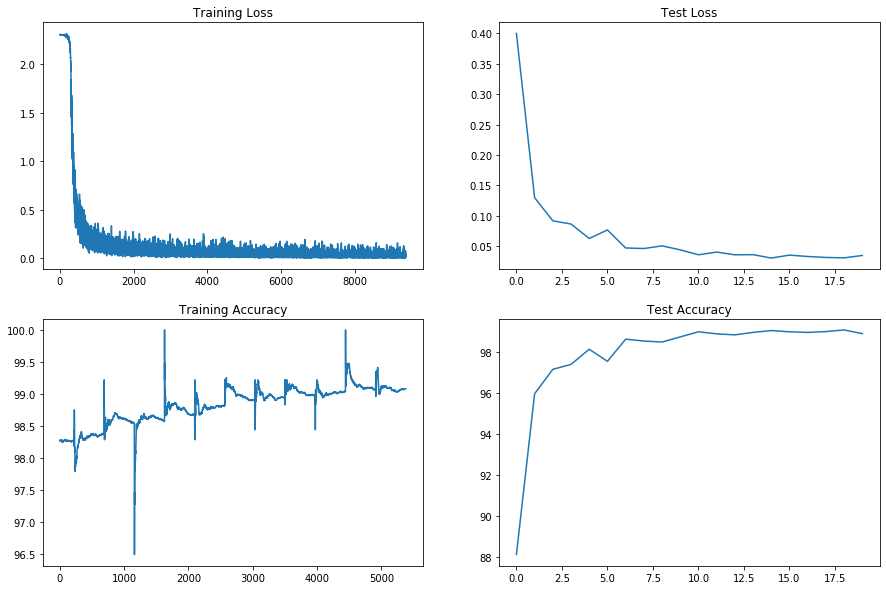

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")